# 9. Showcasing new functionalities: automatic emulator hyperparameters' fitting + LinearMean module with higher than first degree polynomials + mean module fit inspection

In [8]:
import torch

from GPErks.constants import DEFAULT_RANDOM_SEED

# enforce reproducibility
from GPErks.utils.random import set_seed
seed = DEFAULT_RANDOM_SEED
set_seed(seed)

In [9]:
# function to learn (2D -> 1D)
from GPErks.utils.test_functions import currin_exp
d = 2

# build dataset
from GPErks.gp.data.dataset import Dataset
dataset = Dataset.build_from_function(
    currin_exp,
    d,
    n_train_samples=20,
    n_test_samples=25,
    design="lhs",
    seed=seed,
)

In [10]:
# choose likelihood
from gpytorch.likelihoods import GaussianLikelihood
likelihood = GaussianLikelihood()

# choose mean function
# note: can now choose higher than first degree polynomials!
# However, most of the time we can get away with degree=1, I have coded this
# because apparently it is not available anywhere and some people asked to have
# this functionality implemented so here you go!
from GPErks.gp.mean import LinearMean
mean = LinearMean(degree=2, input_size=dataset.input_size, bias=True)

# choose covariance function
from gpytorch.kernels import MaternKernel, ScaleKernel
covar = ScaleKernel(MaternKernel(ard_num_dims=dataset.input_size))

# choose metrics
from torchmetrics import MeanSquaredError, R2Score

from GPErks.utils.metrics import IndependentStandardError
metrics = [MeanSquaredError(), R2Score(), IndependentStandardError()]

# define experiment + device
from GPErks.gp.experiment import GPExperiment
experiment = GPExperiment(
    dataset,
    likelihood,
    mean,
    covar,
    metrics=metrics,
    seed=seed
)
device = "cuda" if torch.cuda.is_available() else "cpu"

In [11]:
# emulator training
# note: can now fit the hyperparameters automatically!
# However, for small training datasets I would still recommend training the
# old-fashioned way; I know that properly using an early stopping criterion to
# manually control training is not simple, but it is more reliable than the
# automatic training presented here in the case when we have only a few points
from GPErks.train.emulator import GPEmulator
emulator = GPEmulator(experiment, device)
emulator.train_auto()
emulator.hyperparameters()

INFO:2025-05-16 17:13:44,121:emulator:train_auto:L205: Training emulator...
INFO:2025-05-16 17:13:44,304:emulator:train_auto:L207: Trained emulator.
INFO:2025-05-16 17:13:44,305:emulator:train_auto:L209: Saving model...
INFO:2025-05-16 17:13:44,306:emulator:train_auto:L214: Saved model.



Bias: 1.7794
Weights: tensor([ 1.2054, -5.6002, -2.2104,  1.0741,  2.5829])
Outputscale: 0.0472
Lengthscales: tensor([    0.0564,   101.7413])
Likelihood noise: 0.0001


                           Score
MeanSquaredError          0.6714
R2Score                   0.9086
IndependentStandardError  0.2400


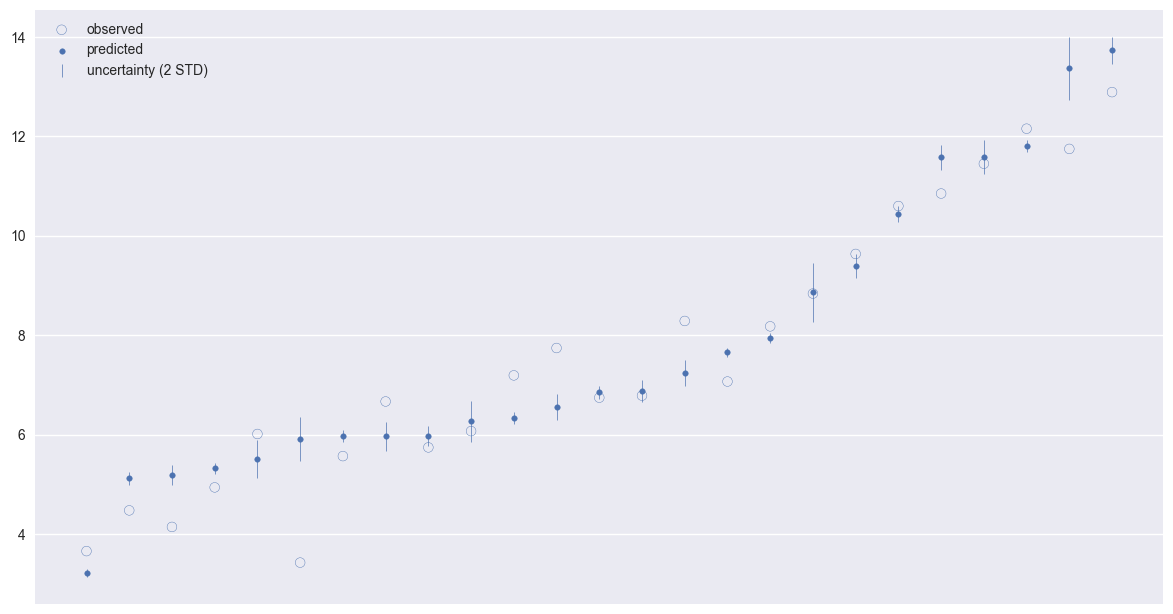

In [12]:
# inference on stored test set
from GPErks.perks.inference import Inference
inference = Inference(emulator)
inference.summary()  # LinearMean with d=2 is not necessarely accurate, try d=1
inference.plot()

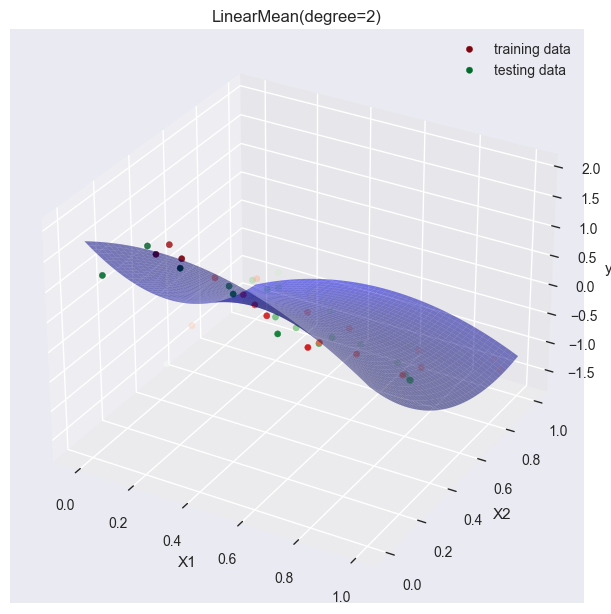

In [13]:
# note: can now inspect the linear mean module fit!
from GPErks.plot.mean import inspect_mean_module
inspect_mean_module(emulator)
